Hola Luis, antes de empezar, me he puesto una guia de pasos de lo que quiero hacer, ira cambiando a medida que haga la practica y vea datos de problema o errores.

1. Cargar los datos
2. Crear la variable de engagement
3. Dividir los datos
4. Preparar los datos
5. Miro si hago CNN, RNN
6. Creo el bucle de entrenamiento
7. Hago la evalucion

El objetivo es hacer un modelo de Inteligencia Artificial capaz de predecir cuánto "Engagement" (éxito/interacción) tendrá un Punto de Interés (POI) turístico en Madrid.

Al principio subia los archivos como module_utils con este codigo

```
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

```
Pero ahora con tantos archivos, tuve que buscar esta otra forma de que recogiera los datos, despues de buscar y probar pude enlazar el drive con el colab, para ello tuve que dar permisos al drive, otra cosa que me dio problemas fue encontrar esto



```
df['full_path'] = df['id'].apply(lambda x: os.path.join(IMAGES_ROOT, x, 'main.jpg'))
```
Antes de contrar la estructura, solo me estaba accediendo a la carpeta pero no a las imagenes. Una cosa a tener en cuenta es que siempre te pide acceso al drive cada vez que lo ejecutas.


In [7]:
from google.colab import drive
import os
import pandas as pd

# 1. Montamos el Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Aqui tuve problemas porque no me di cuenta que la ruta era data_main/data_main y solo ponia data_main

In [8]:
import os
import pandas as pd
from google.colab import drive

BASE_PATH = '/content/drive/MyDrive/PRACTICA DL'
IMAGES_ROOT = os.path.join(BASE_PATH, 'data_main', 'data_main')
csv_path = os.path.join(BASE_PATH, 'poi_dataset.csv')

df = pd.read_csv(csv_path)

df['full_path'] = df['id'].apply(lambda x: os.path.join(IMAGES_ROOT, x, 'main.jpg'))

print(len(df))

1569


No sabia muy bien como plantear engagement, al principio pense en hacer algo asi

```
df['engagement'] = df['Visits'] + df['Likes'] + df['Bookmarks']
```
Pero claro, el peso de cada variable puede ser diferente, por lo que medirlos de la misma forma no iba a generar un entrenamiento real, o eso creo.

Me puse a mirar apps que sean mas o menos por el estilo para ver como estaban hechas,

Con la idea de buscar algun baremo, por ejemplo, en tripadvisor, la torre eifel tiene una puntuacion de 4,5 y casi 5000 comentarios, estos son datos totales, pero por ejemplo tenemos 6 millones de visitantes, que no me dice que todos suban en ascensor, pero es un numero lo suficientemente grande para creer que hay mas visitas, por lo que si lo hago como pensaba el valor de likes y puntuacion no tendria casi relevancia.

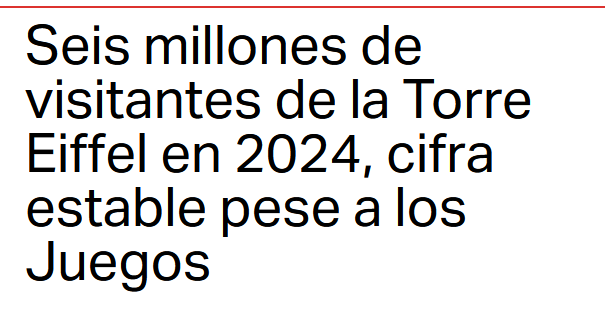

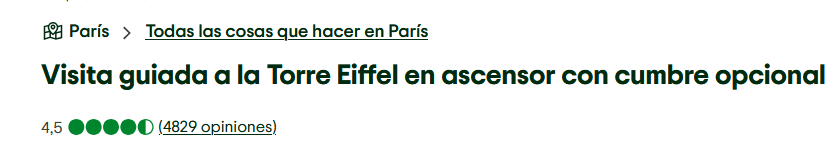

Lo mas sencillo seria hacer un EDA

In [9]:
cols_interaccion = ['Visits', 'Likes', 'Bookmarks', 'Dislikes']
print(df[cols_interaccion].describe())

             Visits         Likes    Bookmarks      Dislikes
count   1569.000000   1569.000000  1569.000000   1569.000000
mean   10011.943276   3623.908222   973.261950   2526.305927
std        5.456808   4817.879374  1453.333948   2225.543360
min    10001.000000    100.000000    50.000000     52.000000
25%    10008.000000    464.000000   116.000000    937.000000
50%    10011.000000   1434.000000   306.000000   2718.000000
75%    10015.000000   6840.000000  1309.000000   3399.000000
max    10038.000000  26425.000000  8157.000000  10999.000000


Claramente las visitas son mayores que el resto de valores, no me esperaba que algunas tuvieran tantos dislikes

Esto es como lo habia hecho antes de la clase del lunes y de que comentaras que lo hicieramos como una clasificacion, asi que lo cambie, lo voy a definir como bajo, medio, alto

```
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
#El tema es el siguiente como no queremos el sumatorio y que los demas valores se pierdan en visita,
#voy a darle pesos a los valores mas o menos en importancia que creo y luego uso standard scaller para normalizar



#Doy unos pesos,
w_visits = 0.01
w_likes = 1.0
w_bookmarks = 5.0
w_dislikes = -0.5

df['raw_score'] = (df['Visits'].fillna(0) * w_visits) + \
                  (df['Likes'].fillna(0) * w_likes) + \
                  (df['Bookmarks'].fillna(0) * w_bookmarks) + \
                  (df['Dislikes'].fillna(0) * w_dislikes)

# Esto para que no salgan negativos
df['raw_score'] = df['raw_score'].apply(lambda x: max(0, x))

# StandarSCALER
scaler = StandardScaler()

# Hago el reshape
target_values = df['raw_score'].values.reshape(-1, 1)
df['target'] = scaler.fit_transform(target_values)

print("Media del target:", df['target'].mean())
print("Desviación típica:", df['target'].std())


#Lo pinto
fig, ax = plt.subplots(figsize=(8, 6))
scaled_target = df['target']

sns.histplot(scaled_target, kde=True, color='orange', ax=ax)
ax.set_title('Standard Scaler', fontsize=14, color='orange')
ax.set_xlabel('Z-Score')

plt.tight_layout()
plt.show()


```



Como puse antes, el codigo anterior era como lo habia hecho, ahora lo que hago es un clasificador en el que categorizo en bajo, medio y alto el conjunto de las variables visits, likes, bookmarks y dislikes lo que sera el engagement_level


Score:
count     1569.000000
mean      7695.117349
std      12389.546530
min          0.000000
25%          0.000000
50%        317.590000
75%      12535.600000
max      63767.050000
Name: raw_score, dtype: float64


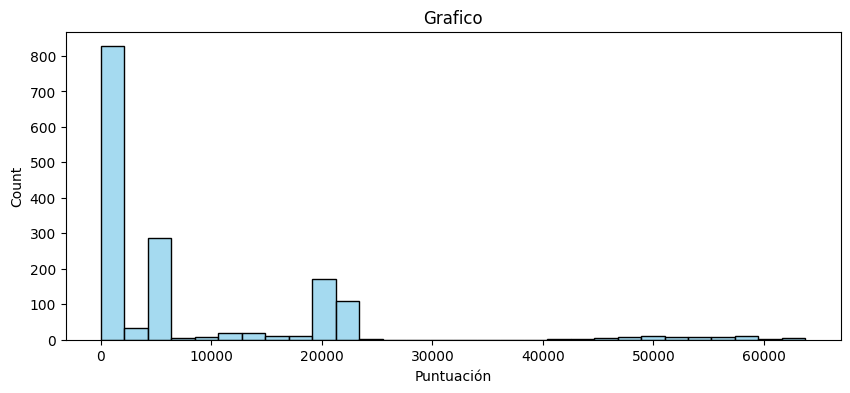

Bajo: < 100.0
Medio: 100.0 - 5329.17
Alto: > 5329.17
Clases resultante:
engagement_level
0    696
2    534
1    339
Name: count, dtype: int64


/tmp/ipython-input-3923247830.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='engagement_level', data=df, palette='viridis')


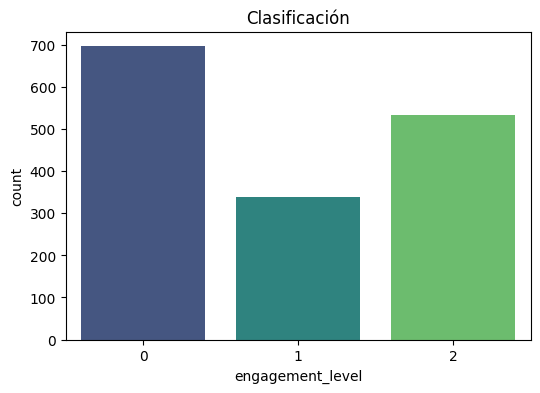

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializo pesos
w_visits = 0.01
w_likes = 1.0
w_bookmarks = 5.0
w_dislikes = -0.5
# raw_score sera la nota numérica que le pongo a cada sitio antes de clasificarlo
df['raw_score'] = (df['Visits'].fillna(0) * w_visits) + \
                  (df['Likes'].fillna(0) * w_likes) + \
                  (df['Bookmarks'].fillna(0) * w_bookmarks) + \
                  (df['Dislikes'].fillna(0) * w_dislikes)

df['raw_score'] = df['raw_score'].apply(lambda x: max(0, x))

print("Score:")
print(df['raw_score'].describe())

# Lo pinto
plt.figure(figsize=(10, 4))
sns.histplot(df['raw_score'], kde=False, color='skyblue')
plt.title("Grafico")
plt.xlabel("Puntuación")
plt.show()

# Cambio esto a 100 para que los que tienen 0 o pocos puntos sean bajos
umbral_bajo = 100.0

# Mantengo este porque  dio 534
umbral_alto = 5329.17

print(f"Bajo: < {umbral_bajo}")
print(f"Medio: {umbral_bajo} - {umbral_alto}")
print(f"Alto: > {umbral_alto}")

# Con esta funcion hago la clasificacion
def clasificacion(score):
    if score < umbral_bajo:
        return 0
    elif score < umbral_alto:
        return 1
    else:
        return 2

#Aplico la funcion
df['engagement_level'] = df['raw_score'].apply(clasificacion)

#Pinto
print("Clases")
print(df['engagement_level'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='engagement_level', data=df, palette='viridis')
plt.title('Clasificación')
plt.show()

Al poner el corte bajo en 100 y el alto en 5329, se han creado tres grupos, bajo 696 - alto 539 - medio 339


Ya me pongo con la separacion de train y test

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

# 70% Entrenar, 15% Validar, 15% Test final

# Primero aparto el 15% de los datos para el test

train_val_df, test_df = train_test_split(
    df,
    test_size=0.15, #
# Uso 'stratify' para que el reparto de clases (0, 1, 2)
# sea el mismo en mis datos de test que en el original, asi no me salen
# descompensados, por ejemplo todos los altos en test
    stratify=df['engagement_level'],
    random_state=42
)


# Ahora me queda el 85% de los datos en 'train_val_df'.
# De ese monton, quiero sacar otro trozo para validacion
# regal de tres, 0.15 (lo que quiero) / 0.85 (lo que tengo) = 0.1765
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,
    stratify=train_val_df['engagement_level'],
    random_state=42
)

#Compruebo con unos prints si los números me cuadran
print(f"Mi set de Entrenamiento (Train): {len(train_df)}")
print(f"Mi set de Validación (Val): {len(val_df)}")
print(f"Mi set de Prueba (Test): {len(test_df)}")


#esto lo he puesto porque me saltaba un error, para que reinicie los indices y no diga que no lo encuentra, aunque luego he puesto .iloc[idx] que lo deberia solucionar sin el reset_index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Mi set de Entrenamiento (Train): 1097
Mi set de Validación (Val): 236
Mi set de Prueba (Test): 236


Ahora voy a tratar las otras variables que no son las que he hecho con engament


In [29]:
from sklearn.preprocessing import StandardScaler

# No uso Visits/Likes porque esas ya las use para crear la respuesta

feature_cols = ['locationLat', 'locationLon', 'xps', 'tier']

# 2. Creo el escalador
scaler = StandardScaler()

#Ajusto el escalador solo con los datos de entrenamiento, asi la media y desviación típica se calculan solo con lo que conoce
scaler.fit(train_df[feature_cols])

#Sobreescribo las columnas originales con los valores escalados.
train_df[feature_cols] = scaler.transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

print(train_df[feature_cols].head(3))

   locationLat  locationLon       xps      tier
0     0.367785    -0.342522  1.087941 -0.844789
1     0.261230    -0.362244  1.087941 -0.844789
2     0.051687    -0.128622 -0.661055  0.699767


Hice una clase dataset propia porque al no tener las imagenes organizadas por carpetas con categorias no puedo hacer torchvision.datasets.ImageFolder, es la unica forma que se me ocurrio, la transformacion lo hago con una convolasional

In [31]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

# He decidido meter "ruido" en el train para obligar a la red a aprender mejor (data augmentation)
train_transforms = transforms.Compose([
# La redimensiono al tamaño estándar de ResNet
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
#Uso la normalizacion estandar de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Para validacion y test no meto ruido

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Creo la clase POIDataset
class POIDataset(Dataset):
    def __init__(self, dataframe, root_dir, feature_cols, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.feature_cols = feature_cols

    def __len__(self):
# Le digo a PyTorch cuántos datos tengo en total en este set
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Busco el nombre de la foto en mi dataframe
        img_name = self.dataframe.iloc[idx]['main_image_path']
# Construyo la ruta completa uniendo la carpeta raíz
        img_path = os.path.join(self.root_dir, img_name)

        try:
# Intento abrirla y asegurarme de que esté en color (RGB)
            image = Image.open(img_path).convert('RGB')
        except:
#Si la imagen falla o no existe
#genero una imagen negra vacía para que mi entrenamiento no explote,
#cojo una imagen negra por la "ausencia de informacion" que es el negro al ser 0 0 0, en este link lo explica
# https://www.geeksforgeeks.org/deep-learning/zero-padding-in-deep-learning-and-signal-processing/
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

# Cojo las columnas que escalé antes y las convierto a tensor de tipo float
        features = torch.tensor(self.dataframe.iloc[idx][self.feature_cols].values.astype('float32'))

# Me aseguro de que sea un entero porque es para clasificación, me dio un error al no ponerlo, auque no me aparecia que era por algo de tipos
        label = torch.tensor(int(self.dataframe.iloc[idx]['engagement_level']))
        return image, features, label


# Aquí sustituyo 'IMAGES_ROOT' por la variable donde guardé la ruta de mis fotos al principio


train_dataset = POIDataset(train_df, IMAGES_ROOT, feature_cols, transform=train_transforms)
val_dataset   = POIDataset(val_df,   IMAGES_ROOT, feature_cols, transform=val_test_transforms)
test_dataset  = POIDataset(test_df,  IMAGES_ROOT, feature_cols, transform=val_test_transforms)
img, feats, lab = train_dataset[0]
print(f"Forma de la imagen: {img.shape}")
print(f"Número de features: {len(feats)}")
print(f"Etiqueta: {lab}")

Forma de la imagen: torch.Size([3, 224, 224])
Número de features: 4
Etiqueta: 1


In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f"DataLoaders")
print(f"Pasos{len(train_loader)}")

DataLoaders listos.
Pasos por época (batches) en Train: 35


He usado una red Resnet18 para qie mire la foto y la resuma en números, sin aprender nada nuevo porque está congelada
he pegado ese resumen de la imagen junto con los datos de mi Excel para que el modelo tenga toda la información junta.

Al final,recibe todo ese paquete mixto y toma la decisión final

> Añadir blockquote



In [34]:
import torch
import torch.nn as nn
from torchvision import models
# Estos son los pasos que voy a seguir
#1. Mirar imagen
#2. Pegarle los datos numéricos
#3. Decidir
class POIModel(nn.Module):
    def __init__(self, num_numerical_features, num_classes=3):
        super(POIModel, self).__init__()
# Uso ResNet18 para que no estemos entrenando horas, lo que nos comentaste en clase
        self.cnn = models.resnet18(pretrained=True)
        for param in self.cnn.parameters():
            param.requires_grad = False
# Cambiamos lo último para que no clasifique
        self.cnn.fc = nn.Identity()
#La entrada sera
        total_inputs = 512 + num_numerical_features
#Una sola capa : de 516 entradas -> a 3 salidas (Clases 0, 1, 2)
        self.classifier = nn.Linear(total_inputs, num_classes)

    def forward(self, image, numerical_data):

#Saco los datos
        features_imagen = self.cnn(image)

# Los juntamos con los números

        features_combinadas = torch.cat((features_imagen, numerical_data), dim=1)

# Decido
        output = self.classifier(features_combinadas)

        return output

# Instancio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = POIModel(num_numerical_features=4)
model = model.to(device)
print(model)

POIModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

La red base esta bien cargada, el identity ha salido bien y las dimesiones de entra y salida coinciden con mi disenio  516 y 3

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
print("Configurando el entrenamiento")

# He tenido que añadir esto porque mi primer modelo predecía siempre la clase mayoritaria, 0
#Para evitarlo, he calculado unos pesos que "castigan" más al modelo si falla en las clases difíciles
weights = torch.tensor([1.0, 2.0, 1.3])
#Me daba error si no enviaba los pesos a la GPU también.
weights = weights.to(device)

#Uso CrossEntropyLoss porque es un problema de clasificación
#Le paso mis pesos para que aplique el castigo extra
criterion = nn.CrossEntropyLoss(weight=weights)
# Uso Adam porque en clase vimos que suele converger más rápido que SGD
# Solo optimizo 'model.classifier.parameters()' porque la parte de la CNN (ResNet) la tengo congelada
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
 # He subido de 10 a 15 porque veía que la gráfica de Loss seguía bajando.
EPOCHS = 15

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):

#Activo el modo 'train' para que capas como Dropout o BatchNorm funcionen como deben
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

#Itero sobre los lotes (batches) de datos
    for images, nums, labels in train_loader:
#Muevo todo a la GPU. Si se me olvida esto, PyTorch se queja de "Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same".
        images, nums, labels = images.to(device), nums.to(device), labels.to(device)

#Al principio se me olvidaba y los gradientes se acumulaban, haciendo que el modelo se volviera loco
        optimizer.zero_grad()
        outputs = model(images, nums)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculo las notas medias de esta época
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    # Cambio a modo 'eval', esto congela capas como Dropout para que la evaluacion sea estable.
    model.eval()

    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

#Uso 'no_grad()' para que no guarde gradientes ni consuma memoria extra.
#Antes no lo ponia y el entrenamiento iba mucho mas lento.
    with torch.no_grad():
        for images, nums, labels in val_loader:
            images, nums, labels = images.to(device), nums.to(device), labels.to(device)

#Solo prediccion, sin aprendizaje
            outputs = model(images, nums)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

#Imprimo el reporte de la época para ver si voy mejorando o si hay Overfitting
    print(f"Época [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

print("¡Entrenamiento finalizado! (Por fin!!!!!!!!!!!!!!!!!!!!!!!!!!!!)")

Configurando el entrenamiento... Cruzando dedos.
Época [1/15] Train Loss: 1.1201 Acc: 36.46% | Val Loss: 1.3854 Acc: 21.61%
Época [2/15] Train Loss: 1.1292 Acc: 35.00% | Val Loss: 1.2752 Acc: 33.90%
Época [3/15] Train Loss: 1.1004 Acc: 35.55% | Val Loss: 1.1037 Acc: 45.34%
Época [4/15] Train Loss: 1.0977 Acc: 36.92% | Val Loss: 1.0816 Acc: 47.03%
Época [5/15] Train Loss: 1.0967 Acc: 39.11% | Val Loss: 1.0892 Acc: 38.14%
Época [6/15] Train Loss: 1.1024 Acc: 38.74% | Val Loss: 1.1199 Acc: 24.15%
Época [7/15] Train Loss: 1.0985 Acc: 41.66% | Val Loss: 1.0813 Acc: 43.22%
Época [8/15] Train Loss: 1.0894 Acc: 42.94% | Val Loss: 1.0795 Acc: 44.92%
Época [9/15] Train Loss: 1.0820 Acc: 43.12% | Val Loss: 1.1186 Acc: 23.73%
Época [10/15] Train Loss: 1.0869 Acc: 42.48% | Val Loss: 1.0951 Acc: 42.37%
Época [11/15] Train Loss: 1.0847 Acc: 42.48% | Val Loss: 1.0877 Acc: 45.34%
Época [12/15] Train Loss: 1.1119 Acc: 41.39% | Val Loss: 1.0777 Acc: 46.19%
Época [13/15] Train Loss: 1.0928 Acc: 42.75% | V

Realizando eval

Clasificacion
              precision    recall  f1-score   support

    Bajo (0)       0.57      0.48      0.52       105
   Medio (1)       0.50      0.02      0.04        51
    Alto (2)       0.38      0.70      0.50        80

    accuracy                           0.45       236
   macro avg       0.48      0.40      0.35       236
weighted avg       0.49      0.45      0.41       236



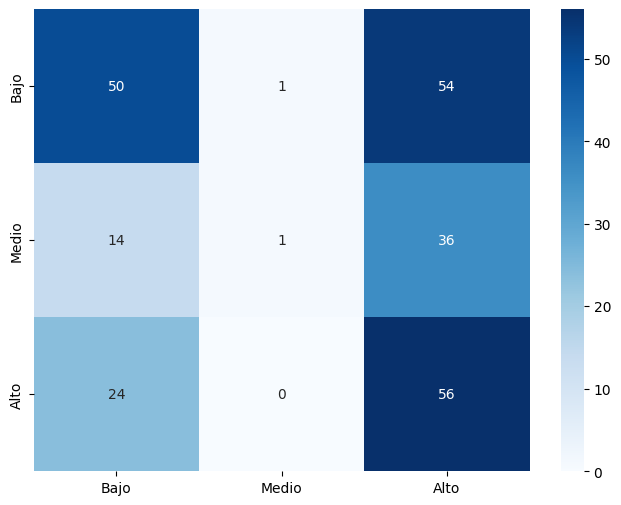

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Hago la evaluacion
model.eval()
y_pred = []
y_true = []

print("Realizando eval")

#bucle de predicción
with torch.no_grad():
    for images, nums, labels in test_loader:
# Mover a GPU
        images, nums, labels = images.to(device), nums.to(device), labels.to(device)
# Predecir
        outputs = model(images, nums)
#Convertir probabilidades a clase
        _, predicted = torch.max(outputs, 1)
#Guardar resultados (los pasamos a la CPU para usar sklearn)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
print("\nClasificacion")
print(classification_report(y_true, y_pred, target_names=['Bajo (0)', 'Medio (1)', 'Alto (2)']))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
plt.show()

Estas son mis conclusiones

El modelo ha obtenido una Accuracy global del 45%. A primera vista parece bajo, si el modelo hubiera sido 'vago' y hubiera predicho siempre la clase mayoritaria (Bajo), habría acertado un 44%. Mi modelo apenas supera esa línea base en general, lo que indica que le está costando encontrar patrones visuales claros que diferencien las categorias

En la clase alta hemos logrado un 70%, es un buen resultado

De los 51 sitios de categoría 'Media', el modelo solo ha encontrado 1. Ha ignorado completamente esta categoria, tengo que darle una vuelta, porque claramente algo esta fallando aqui.

Ahora mis conclusiones subjetivas, creo que el modelo esta correcto, he ido corrigiendo, en los comentarios comento que cosas he ido cambiando o donde he tenido problemas, pero no es un buen resultado, porque solo en alto hace una buena prediccion.

Me he visto un poco perdido porque no sabia si el objetivo final era este, me refiero, no hemos tenido ningun ejemplo parecido por lo que no se si el enfoque que le he dado es el correcto o te he entendido mal, ya me dices